In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
from data import load_ff3

In [16]:
# results_max_dir = 'results/models/max'
# results_weighted_dir = 'results/models/weighted'

results_max_dir = 'results/max_L'
results_maxmin_dir = 'results/max-min_LS'
results_weighted_dir = 'results/weighted_LS'

strat_names_max = os.listdir(results_max_dir)
strat_names_maxmin = os.listdir(results_maxmin_dir)
strat_names_weighted = os.listdir(results_weighted_dir)

strat_cum_rets_max = {}
strat_cum_rets_maxmin = {}
strat_cum_rets_weighted = {}

strat_metrics_max = {}
strat_metrics_maxmin = {}
strat_metrics_weighted = {}

for strat_name in strat_names_max:
    strat_cum_rets_max[strat_name] = pd.read_csv(os.path.join(results_max_dir, strat_name, 'cumulative_returns.csv'), index_col=0)
    strat_metrics_max[strat_name] = json.load(open(os.path.join(results_max_dir, strat_name, 'params.json'), 'r'))
    
for strat_name in strat_names_maxmin:
    strat_cum_rets_maxmin[strat_name] = pd.read_csv(os.path.join(results_maxmin_dir, strat_name, 'cumulative_returns.csv'), index_col=0)
    strat_metrics_maxmin[strat_name] = json.load(open(os.path.join(results_maxmin_dir, strat_name, 'params.json'), 'r'))
    
for strat_name in strat_names_weighted:
    strat_cum_rets_weighted[strat_name] = pd.read_csv(os.path.join(results_weighted_dir, strat_name, 'cumulative_returns.csv'), index_col=0)
    strat_metrics_weighted[strat_name] = json.load(open(os.path.join(results_weighted_dir, strat_name, 'params.json'), 'r'))
    
    
# Sort each dict by dict name
strat_cum_rets_max = dict(sorted(strat_cum_rets_max.items(), key=lambda x: len(x[0])))
strat_cum_rets_maxmin = dict(sorted(strat_cum_rets_maxmin.items(), key=lambda x: len(x[0])))
strat_cum_rets_weighted = dict(sorted(strat_cum_rets_weighted.items(), key=lambda x: len(x[0])))

strat_metrics_max = dict(sorted(strat_metrics_max.items(), key=lambda x: len(x[0])))
strat_metrics_maxmin = dict(sorted(strat_metrics_maxmin.items(), key=lambda x: len(x[0])))
strat_metrics_weighted = dict(sorted(strat_metrics_weighted.items(), key=lambda x: len(x[0])))

len(strat_cum_rets_max), len(strat_cum_rets_weighted), len(strat_metrics_max), len(strat_metrics_weighted)

(25, 25, 25, 25)

In [17]:
def calc_sharpe(cum_rets, rf_ret):
    # Get monthly returns
    daily_rets = cum_rets.pct_change().dropna()
    daily_rets.index = pd.to_datetime(daily_rets.index, format='%Y-%m-%d')
    
    merge = pd.merge(daily_rets, rf_ret, left_index=True, right_index=True)

    # Calculate sharpe ratio
    sharpe = ((merge['0']*100 - merge['RF']) / (merge['0']*100).std()).mean()
    return sharpe

ff3_daily = load_ff3()
ff3_daily = ff3_daily[ff3_daily.index >= 20180305]
ff3_daily.index = pd.to_datetime(ff3_daily.index, format='%Y%m%d')

for strat_name, metric in strat_metrics_max.items():
    sharpe = calc_sharpe(strat_cum_rets_max[strat_name], ff3_daily['RF'])
    metric['sharpe'] = sharpe

for strat_name, metric in strat_metrics_maxmin.items():
    sharpe = calc_sharpe(strat_cum_rets_maxmin[strat_name], ff3_daily['RF'])
    metric['sharpe'] = sharpe

for strat_name, metric in strat_metrics_weighted.items():
    sharpe = calc_sharpe(strat_cum_rets_weighted[strat_name], ff3_daily['RF'])
    metric['sharpe'] = sharpe

In [18]:
ff3_daily = pd.read_csv('ff3_daily.csv', index_col=0)

In [19]:
def plot_cum_rets(cum_rets: dict[str, pd.DataFrame], title: str, figsize=(10, 6), ff3_daily=ff3_daily):
    if len(cum_rets) == 0:
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    for strat_name in cum_rets.keys():
        rets = cum_rets[strat_name]
        rets.index = pd.to_datetime(rets.index)
        rets_monthly = rets.resample('ME').last()
        
        first_date = int(f"{rets_monthly.index[0].year}{'0' if rets_monthly.index[0].month < 10 else ''}{rets_monthly.index[0].month}{'0' if rets_monthly.index[0].day < 10 else ''}{rets_monthly.index[0].day}")
        
        ax.plot(rets_monthly.index, rets_monthly.values, label=strat_name)

    ff3_daily.index = pd.to_datetime(ff3_daily.index, format='%Y%m%d')
    ff3_daily = ff3_daily[ff3_daily.index > pd.to_datetime(first_date, format='%Y%m%d')]
    mkt_cum_rets_daily = (1 + (ff3_daily['Mkt-RF'] + ff3_daily['RF']) / 100).cumprod()
    mkt_cum_rets_monthly = mkt_cum_rets_daily.resample('ME').last()
    ax.plot(mkt_cum_rets_monthly.index, mkt_cum_rets_monthly.values, label='Market')
    
    ax.legend()
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title(title)
    plt.show()

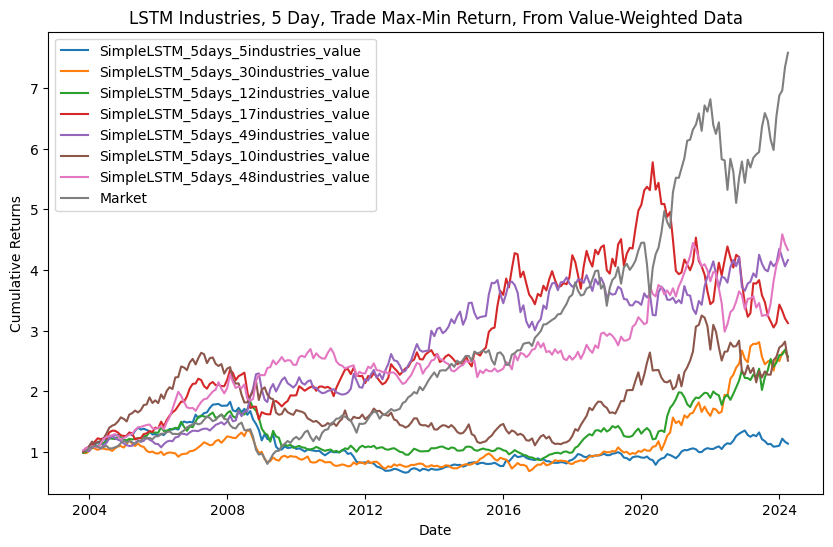

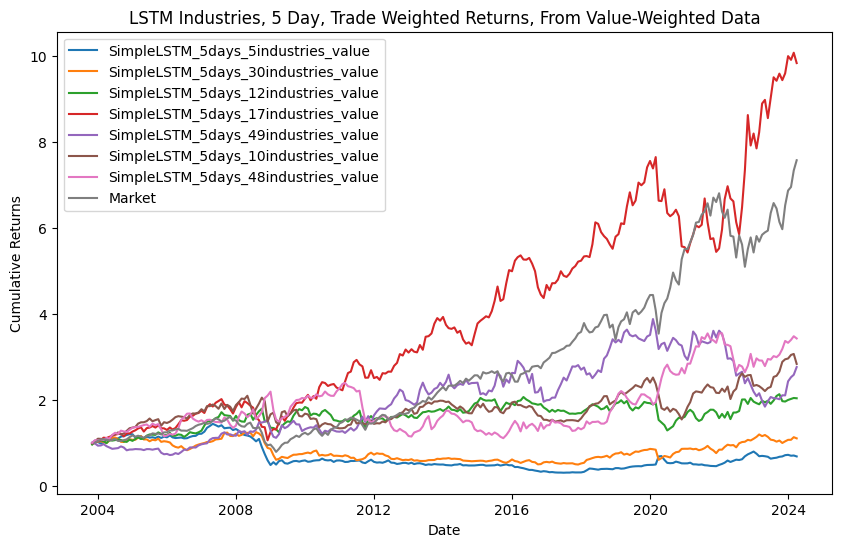

In [20]:
lstm_industries_max_equal_5 = {}
lstm_industries_max_equal_metrics_5 = {}
for name, rets in strat_cum_rets_max.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'equal' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        lstm_industries_max_equal_5[name] = rets
        lstm_industries_max_equal_metrics_5[name] = strat_metrics_max[name]
        
lstm_industries_max_value_5 = {}
lstm_industries_max_value_metrics_5 = {}
for name, rets in strat_cum_rets_max.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'value' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        lstm_industries_max_value_5[name] = rets
        lstm_industries_max_value_metrics_5[name] = strat_metrics_max[name]
        
lstm_industries_maxmin_equal_5 = {}
lstm_industries_maxmin_equal_metrics_5 = {}
for name, rets in strat_cum_rets_maxmin.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'equal' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        lstm_industries_maxmin_equal_5[name] = rets
        lstm_industries_maxmin_equal_metrics_5[name] = strat_metrics_maxmin[name]
        
lstm_industries_maxmin_value_5 = {}
lstm_industries_maxmin_value_metrics_5 = {}
for name, rets in strat_cum_rets_maxmin.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'value' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        lstm_industries_maxmin_value_5[name] = rets
        lstm_industries_maxmin_value_metrics_5[name] = strat_metrics_maxmin[name]

lstm_industries_weighted_equal_5 = {}
lstm_industries_weighted_equal_metrics_5 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'equal' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        lstm_industries_weighted_equal_5[name] = rets
        lstm_industries_weighted_equal_metrics_5[name] = strat_metrics_weighted[name]
                
lstm_industries_weighted_value_5 = {}
lstm_industries_weighted_value_metrics_5 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'value' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        lstm_industries_weighted_value_5[name] = rets
        lstm_industries_weighted_value_metrics_5[name] = strat_metrics_weighted[name]

# plot_cum_rets(lstm_industries_max_equal_5, 'LSTM Industries, 5 Day, Trade Max Return, From Equal-Weighted Data')
# plot_cum_rets(lstm_industries_max_value_5, 'LSTM Industries, 5 Day, Trade Max Return, From Value-Weighted Data')

plot_cum_rets(lstm_industries_maxmin_equal_5, 'LSTM Industries, 5 Day, Trade Max-Min Return, From Equal-Weighted Data')
plot_cum_rets(lstm_industries_maxmin_value_5, 'LSTM Industries, 5 Day, Trade Max-Min Return, From Value-Weighted Data')

plot_cum_rets(lstm_industries_weighted_equal_5, 'LSTM Industries, 5 Day, Trade Weighted Returns, From Equal-Weighted Data')
plot_cum_rets(lstm_industries_weighted_value_5, 'LSTM Industries, 5 Day, Trade Weighted Returns, From Value-Weighted Data')

In [21]:
# Same but _22
lstm_industries_max_equal_22 = {}
lstm_industries_max_equal_metrics_22 = {}
for name, rets in strat_cum_rets_max.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'equal' in name.lower() and '38' not in name.lower() and '22days' in name.lower():
        lstm_industries_max_equal_22[name] = rets
        lstm_industries_max_equal_metrics_22[name] = strat_metrics_max[name]
        
lstm_industries_max_value_22 = {}
lstm_industries_max_value_metrics_22 = {}
for name, rets in strat_cum_rets_max.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'value' in name.lower() and '38' not in name.lower() and '22days' in name.lower():
        lstm_industries_max_value_22[name] = rets
        lstm_industries_max_value_metrics_22[name] = strat_metrics_max[name]
        
lstm_industries_weighted_equal_22 = {}
lstm_industries_weighted_equal_metrics_22 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'equal' in name.lower() and '38' not in name.lower() and '22days' in name.lower():
        lstm_industries_weighted_equal_22[name] = rets
        lstm_industries_weighted_equal_metrics_22[name] = strat_metrics_weighted[name]
        
lstm_industries_weighted_value_22 = {}
lstm_industries_weighted_value_metrics_22 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'lstm' in name.lower() and 'industries' in name.lower() and 'value' in name.lower() and '38' not in name.lower() and '22days' in name.lower():
        lstm_industries_weighted_value_22[name] = rets
        lstm_industries_weighted_value_metrics_22[name] = strat_metrics_weighted[name]
        
plot_cum_rets(lstm_industries_max_equal_22, 'LSTM Industries, 22 Day, Trade Max Return, From Equal-Weighted Data')
plot_cum_rets(lstm_industries_max_value_22, 'LSTM Industries, 22 Day, Trade Max Return, From Value-Weighted Data')
plot_cum_rets(lstm_industries_weighted_equal_22, 'LSTM Industries, 22 Day, Trade Weighted Returns, From Equal-Weighted Data')
plot_cum_rets(lstm_industries_weighted_value_22, 'LSTM Industries, 22 Day, Trade Weighted Returns, From Value-Weighted Data')

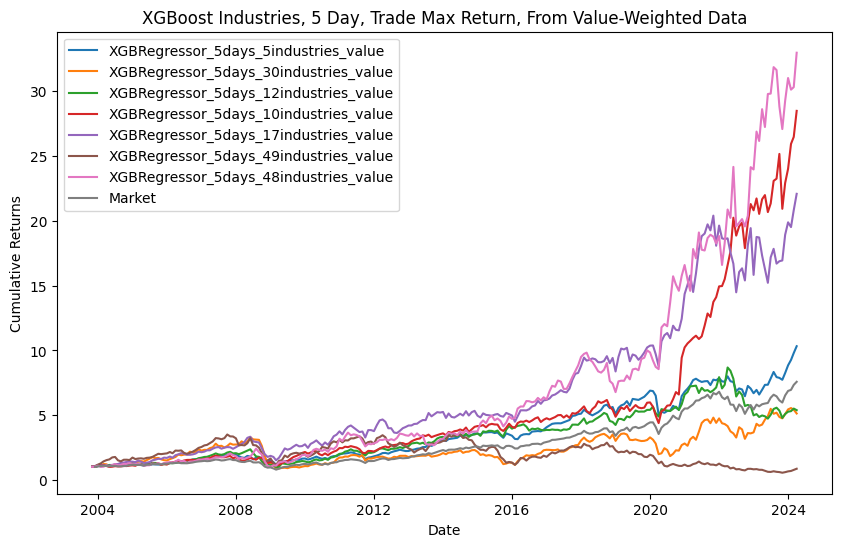

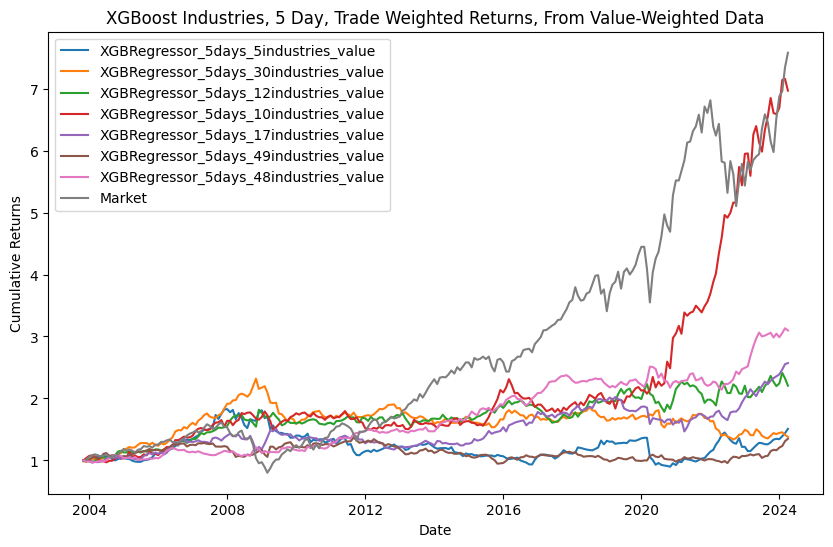

In [22]:
XGBRegressor_industries_max_equal_5 = {}
XGBRegressor_industries_max_equal_metrics_5 = {}
for name, rets in strat_cum_rets_max.items():
    if 'XGBRegressor' in name and 'industries' in name.lower() and 'equal' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        XGBRegressor_industries_max_equal_5[name] = rets
        XGBRegressor_industries_max_equal_metrics_5[name] = strat_metrics_max[name]

XGBRegressor_industries_max_value_5 = {}
XGBRegressor_industries_max_value_metrics_5 = {}
for name, rets in strat_cum_rets_max.items():
    if 'XGBRegressor' in name and 'industries' in name.lower() and 'value' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        XGBRegressor_industries_max_value_5[name] = rets
        XGBRegressor_industries_max_value_metrics_5[name] = strat_metrics_max[name]

XGBRegressor_industries_weighted_equal_5 = {}
XGBRegressor_industries_weighted_equal_metrics_5 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'XGBRegressor' in name and 'industries' in name.lower() and 'equal' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        XGBRegressor_industries_weighted_equal_5[name] = rets
        XGBRegressor_industries_weighted_equal_metrics_5[name] = strat_metrics_weighted[name]

XGBRegressor_industries_weighted_value_5 = {}
XGBRegressor_industries_weighted_value_metrics_5 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'XGBRegressor' in name and 'industries' in name.lower() and 'value' in name.lower() and '38' not in name.lower() and '5days' in name.lower():
        XGBRegressor_industries_weighted_value_5[name] = rets
        XGBRegressor_industries_weighted_value_metrics_5[name] = strat_metrics_weighted[name]

plot_cum_rets(XGBRegressor_industries_max_equal_5, 'XGBoost Industries, 5 Day, Trade Max Return, From Equal-Weighted Data')
plot_cum_rets(XGBRegressor_industries_max_value_5, 'XGBoost Industries, 5 Day, Trade Max Return, From Value-Weighted Data')
plot_cum_rets(XGBRegressor_industries_weighted_equal_5, 'XGBoost Industries, 5 Day, Trade Weighted Returns, From Equal-Weighted Data')
plot_cum_rets(XGBRegressor_industries_weighted_value_5, 'XGBoost Industries, 5 Day, Trade Weighted Returns, From Value-Weighted Data')

In [23]:
# Do the same but for 22 days
XGBRegressor_industries_max_equal_22 = {}
XGBRegressor_industries_max_equal_metrics_22 = {}
for name, rets in strat_cum_rets_max.items():
    if 'XGBRegressor' in name and 'industries' in name.lower() and 'equal' in name.lower() and '38' not in name.lower() and '22days' in name.lower():
        XGBRegressor_industries_max_equal_22[name] = rets
        XGBRegressor_industries_max_equal_metrics_22[name] = strat_metrics_max[name]
        
XGBRegressor_industries_max_value_22 = {}
XGBRegressor_industries_max_value_metrics_22 = {}
for name, rets in strat_cum_rets_max.items():
    if 'XGBRegressor' in name and 'industries' in name.lower() and 'value' in name.lower() and '38' not in name.lower() and '22days' in name.lower():
        XGBRegressor_industries_max_value_22[name] = rets
        XGBRegressor_industries_max_value_metrics_22[name] = strat_metrics_max[name]
        
XGBRegressor_industries_weighted_equal_22 = {}
XGBRegressor_industries_weighted_equal_metrics_22 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'XGBRegressor' in name and 'industries' in name.lower() and 'equal' in name.lower() and '38' not in name.lower() and '22days' in name.lower():
        XGBRegressor_industries_weighted_equal_22[name] = rets
        XGBRegressor_industries_weighted_equal_metrics_22[name] = strat_metrics_weighted[name]
        
XGBRegressor_industries_weighted_value_22 = {}
XGBRegressor_industries_weighted_value_metrics_22 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'XGBRegressor' in name and 'industries' in name.lower() and 'value' in name.lower() and '38' not in name.lower() and '22days' in name.lower():
        XGBRegressor_industries_weighted_value_22[name] = rets
        XGBRegressor_industries_weighted_value_metrics_22[name] = strat_metrics_weighted[name] 
        
plot_cum_rets(XGBRegressor_industries_max_equal_22, 'XGBoost Industries, 22 Day, Trade Max Return, From Equal-Weighted Data')
plot_cum_rets(XGBRegressor_industries_max_value_22, 'XGBoost Industries, 22 Day, Trade Max Return, From Value-Weighted Data')
plot_cum_rets(XGBRegressor_industries_weighted_equal_22, 'XGBoost Industries, 22 Day, Trade Weighted Returns, From Equal-Weighted Data')
plot_cum_rets(XGBRegressor_industries_weighted_value_22, 'XGBoost Industries, 22 Day, Trade Weighted Returns, From Value-Weighted Data')

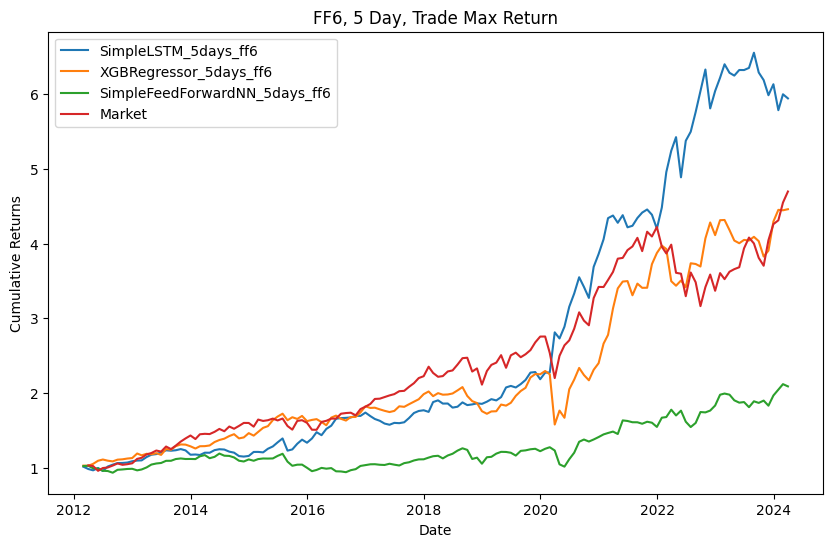

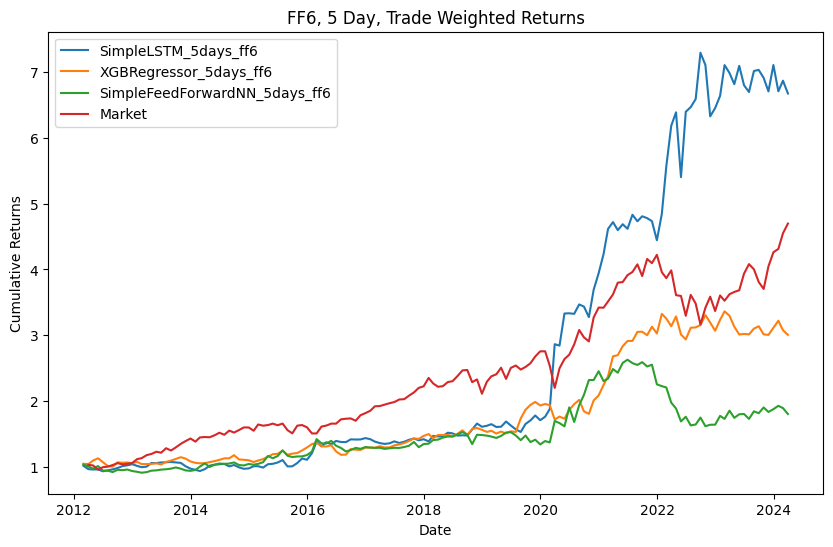

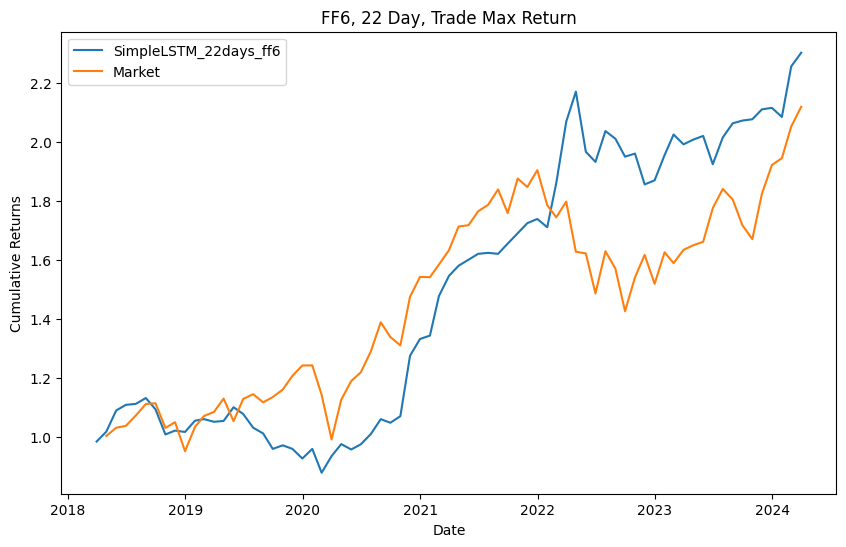

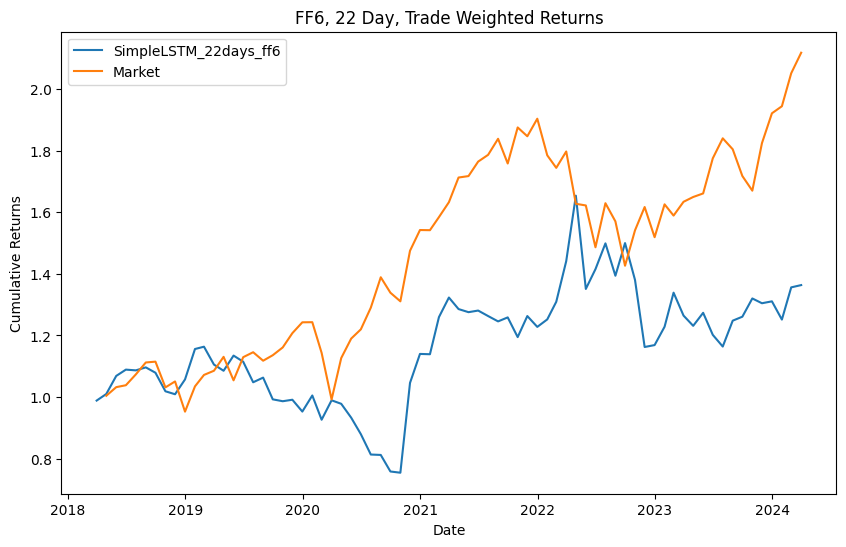

In [24]:
ff6_max_5 = {}
ff6_max_metrics_5 = {}
for name, rets in strat_cum_rets_max.items():
    if 'ff6' in name.lower() and '5days' in name.lower():
        ff6_max_5[name] = rets
        ff6_max_metrics_5[name] = strat_metrics_max[name]

ff6_weighted_5 = {}
ff6_weighted_metrics_5 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'ff6' in name.lower() and '5days' in name.lower():
        ff6_weighted_5[name] = rets
        ff6_weighted_metrics_5[name] = strat_metrics_weighted[name]
   
ff6_max_22 = {}
ff6_max_metrics_22 = {}
for name, rets in strat_cum_rets_max.items():
    if 'ff6' in name.lower() and '22days' in name.lower():
        ff6_max_22[name] = rets
        ff6_max_metrics_22[name] = strat_metrics_max[name]
   
ff6_weighted_22 = {}
ff6_weighted_metrics_22 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'ff6' in name.lower() and '22days' in name.lower():
        ff6_weighted_22[name] = rets
        ff6_weighted_metrics_22[name] = strat_metrics_weighted[name]
           
        
plot_cum_rets(ff6_max_5, 'FF6, 5 Day, Trade Max Return')
plot_cum_rets(ff6_weighted_5, 'FF6, 5 Day, Trade Weighted Returns')
plot_cum_rets(ff6_max_22, 'FF6, 22 Day, Trade Max Return')
plot_cum_rets(ff6_weighted_22, 'FF6, 22 Day, Trade Weighted Returns')

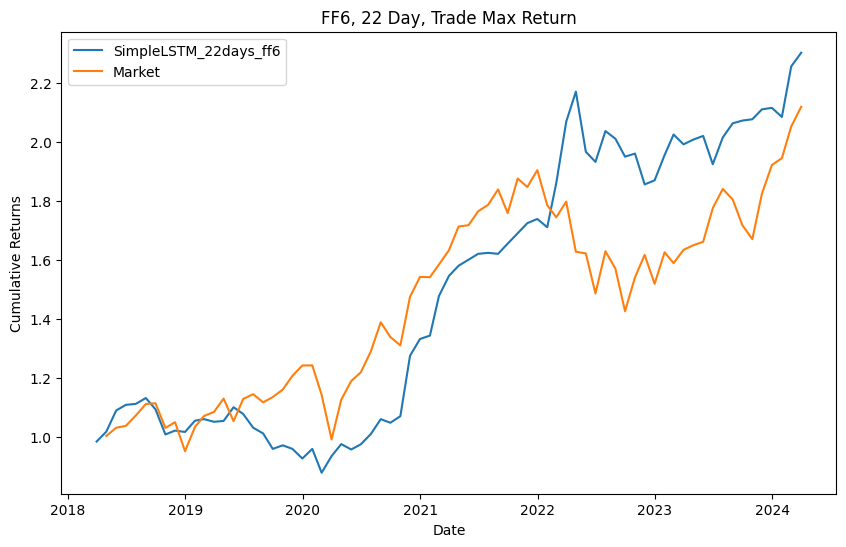

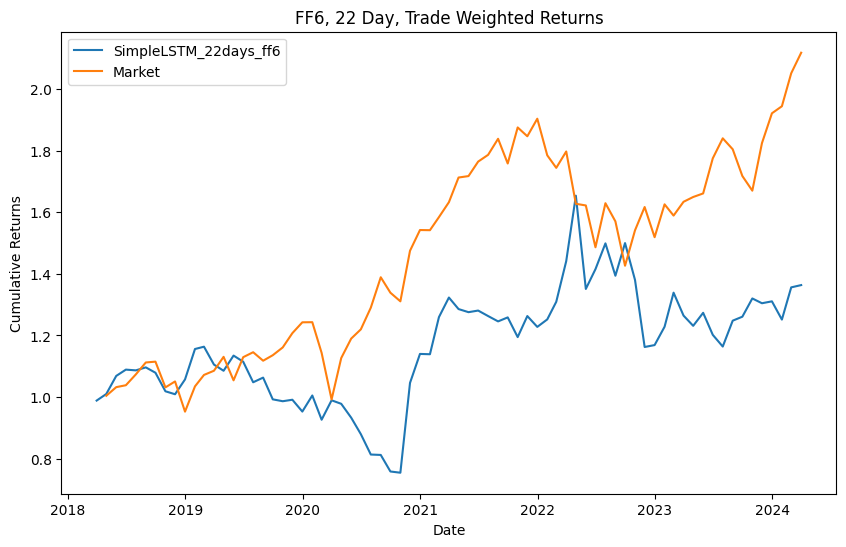

In [25]:
ff6_max_22 = {}
ff6_max_metrics_22 = {}
for name, rets in strat_cum_rets_max.items():
    if 'ff6' in name.lower() and '22days' in name.lower():
        ff6_max_22[name] = rets
        ff6_max_metrics_22[name] = strat_metrics_max[name]
        
ff6_weighted_22 = {}
ff6_weighted_metrics_22 = {}
for name, rets in strat_cum_rets_weighted.items():
    if 'ff6' in name.lower() and '22days' in name.lower():
        ff6_weighted_22[name] = rets
        ff6_weighted_metrics_22[name] = strat_metrics_weighted[name]
        
plot_cum_rets(ff6_max_22, 'FF6, 22 Day, Trade Max Return')
plot_cum_rets(ff6_weighted_22, 'FF6, 22 Day, Trade Weighted Returns')

In [26]:
# Make df for each metrics dict
df_metrics_dict = {}

df_metrics_dict['lstm_industries_max_equal_metrics_5'] = pd.DataFrame(lstm_industries_max_equal_metrics_5).T
df_metrics_dict['lstm_industries_max_value_metrics_5'] = pd.DataFrame(lstm_industries_max_value_metrics_5).T
df_metrics_dict['lstm_industries_weighted_equal_metrics_5'] = pd.DataFrame(lstm_industries_weighted_equal_metrics_5).T
df_metrics_dict['lstm_industries_weighted_value_metrics_5'] = pd.DataFrame(lstm_industries_weighted_value_metrics_5).T

df_metrics_dict['lstm_industries_max_equal_metrics_22'] = pd.DataFrame(lstm_industries_max_equal_metrics_22).T
df_metrics_dict['lstm_industries_max_value_metrics_22'] = pd.DataFrame(lstm_industries_max_value_metrics_22).T
df_metrics_dict['lstm_industries_weighted_equal_metrics_22'] = pd.DataFrame(lstm_industries_weighted_equal_metrics_22).T
df_metrics_dict['lstm_industries_weighted_value_metrics_22'] = pd.DataFrame(lstm_industries_weighted_value_metrics_22).T

df_metrics_dict['XGBRegressor_industries_max_equal_metrics_5'] = pd.DataFrame(XGBRegressor_industries_max_equal_metrics_5).T
df_metrics_dict['XGBRegressor_industries_max_value_metrics_5'] = pd.DataFrame(XGBRegressor_industries_max_value_metrics_5).T
df_metrics_dict['XGBRegressor_industries_weighted_equal_metrics_5'] = pd.DataFrame(XGBRegressor_industries_weighted_equal_metrics_5).T
df_metrics_dict['XGBRegressor_industries_weighted_value_metrics_5'] = pd.DataFrame(XGBRegressor_industries_weighted_value_metrics_5).T

df_metrics_dict['XGBRegressor_industries_max_equal_metrics_22'] = pd.DataFrame(XGBRegressor_industries_max_equal_metrics_22).T
df_metrics_dict['XGBRegressor_industries_max_value_metrics_22'] = pd.DataFrame(XGBRegressor_industries_max_value_metrics_22).T
df_metrics_dict['XGBRegressor_industries_weighted_equal_metrics_22'] = pd.DataFrame(XGBRegressor_industries_weighted_equal_metrics_22).T
df_metrics_dict['XGBRegressor_industries_weighted_value_metrics_22'] = pd.DataFrame(XGBRegressor_industries_weighted_value_metrics_22).T

df_metrics_dict['ff6_max_metrics_5'] = pd.DataFrame(ff6_max_metrics_5).T
df_metrics_dict['ff6_weighted_metrics_5'] = pd.DataFrame(ff6_weighted_metrics_5).T

df_metrics_dict['ff6_max_metrics_22'] = pd.DataFrame(ff6_max_metrics_22).T
df_metrics_dict['ff6_weighted_metrics_22'] = pd.DataFrame(ff6_weighted_metrics_22).T


def highlight(data, color='yellow'):
    attr = 'font-weight: bold'
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

# Specify the columns you want to highlight
columns_to_highlight = ['alpha']

for df_name, df in df_metrics_dict.items():
    # If df is empty, skip
    if df.empty:
        continue
    styled_df = df.style.apply(highlight, subset=columns_to_highlight)
    print(df_name)
    display(styled_df)

lstm_industries_max_value_metrics_5


,alpha,alpha_annual,alpha_p_value,beta,beta_p_value,sharpe
SimpleLSTM_5days_5industries_value,0.000612,0.161707,0.935321,1.014210,0.000000,0.042250
SimpleLSTM_5days_30industries_value,0.017866,4.829232,0.243221,1.033442,0.000000,0.068861
SimpleLSTM_5days_12industries_value,0.020455,5.547869,0.087256,0.976239,0.000000,0.048038
SimpleLSTM_5days_17industries_value,0.016288,4.393373,0.269731,1.083825,0.000000,0.024968
SimpleLSTM_5days_49industries_value,0.016150,4.355475,0.336969,0.934170,0.000000,0.037639
SimpleLSTM_5days_10industries_value,0.021721,5.901190,0.079100,0.945864,0.000000,0.064707
SimpleLSTM_5days_48industries_value,0.042391,11.838745,0.047030,0.930611,0.000000,0.058174


lstm_industries_weighted_value_metrics_5


,alpha,alpha_annual,alpha_p_value,beta,beta_p_value,sharpe
SimpleLSTM_5days_5industries_value,-0.012987,-3.370783,0.386216,0.152703,0.000000,0.033411
SimpleLSTM_5days_30industries_value,-0.009154,-2.387836,0.515100,0.277044,0.000000,0.032904
SimpleLSTM_5days_12industries_value,0.003007,0.797114,0.847514,0.299865,0.000000,0.006833
SimpleLSTM_5days_17industries_value,0.036039,9.979766,0.035770,0.264934,0.000000,0.029774
SimpleLSTM_5days_49industries_value,0.014876,4.005203,0.371227,0.165534,0.000000,0.004291
SimpleLSTM_5days_10industries_value,0.009509,2.542036,0.545153,0.298642,0.000000,0.024671
SimpleLSTM_5days_48industries_value,0.019645,5.322623,0.255703,0.164588,0.000000,0.043948


XGBRegressor_industries_max_value_metrics_5


,alpha,alpha_annual,alpha_p_value,beta,beta_p_value,sharpe
XGBRegressor_5days_5industries_value,0.008272,2.207737,0.264936,0.959218,0.000000,0.033659
XGBRegressor_5days_30industries_value,0.000109,0.028655,0.995325,1.065669,0.000000,0.023586
XGBRegressor_5days_12industries_value,-0.003086,-0.811529,0.793604,0.992203,0.000000,0.012164
XGBRegressor_5days_10industries_value,0.030264,8.316101,0.010207,0.961708,0.000000,0.069115
XGBRegressor_5days_17industries_value,0.023711,6.458941,0.087398,1.094971,0.000000,0.036733
XGBRegressor_5days_49industries_value,-0.031630,-8.012283,0.105857,0.982951,0.000000,-0.031947
XGBRegressor_5days_48industries_value,0.039967,11.125705,0.046315,0.983227,0.000000,0.046840


XGBRegressor_industries_weighted_value_metrics_5


,alpha,alpha_annual,alpha_p_value,beta,beta_p_value,sharpe
XGBRegressor_5days_5industries_value,0.002783,0.737462,0.813684,0.080944,0.000000,0.012768
XGBRegressor_5days_30industries_value,0.001778,0.470592,0.843031,0.026135,0.000697,-0.028858
XGBRegressor_5days_12industries_value,0.011183,2.996289,0.250938,0.027697,0.000923,0.014539
XGBRegressor_5days_10industries_value,0.034391,9.502355,0.001696,0.023845,0.011160,0.082786
XGBRegressor_5days_17industries_value,0.014218,3.824664,0.141984,0.025880,0.001840,0.019939
XGBRegressor_5days_49industries_value,0.001346,0.355919,0.861015,0.012151,0.065391,0.014148
XGBRegressor_5days_48industries_value,0.017697,4.782529,0.018789,0.006293,0.329947,0.025306


ff6_max_metrics_5


,alpha,alpha_annual,alpha_p_value,beta,beta_p_value,sharpe
SimpleLSTM_5days_ff6,0.046546,13.071933,0.002335,0.230472,0.000000,0.066875
XGBRegressor_5days_ff6,0.036589,10.139369,0.013465,0.245009,0.000000,0.048102
SimpleFeedForwardNN_5days_ff6,0.009208,2.460557,0.553305,0.298078,0.000000,0.033009


ff6_weighted_metrics_5


,alpha,alpha_annual,alpha_p_value,beta,beta_p_value,sharpe
SimpleLSTM_5days_ff6,0.069297,20.067134,0.000439,-0.073329,0.000077,0.071917
XGBRegressor_5days_ff6,0.038788,10.780574,0.024100,-0.020898,0.196184,0.039698
SimpleFeedForwardNN_5days_ff6,0.023328,6.351498,0.219348,-0.037691,0.034892,0.013631


ff6_max_metrics_22


,alpha,alpha_annual,alpha_p_value,beta,beta_p_value,sharpe
SimpleLSTM_22days_ff6,0.041672,11.626808,0.135190,0.274962,0.000000,0.046308


ff6_weighted_metrics_22


,alpha,alpha_annual,alpha_p_value,beta,beta_p_value,sharpe
SimpleLSTM_22days_ff6,0.026411,7.220228,0.480307,-0.011482,0.693574,0.016046


In [27]:
cols = ['alpha', 'alpha_annual', 'alpha_p_value', 'beta', 'sharpe']
metrics_df = pd.DataFrame(columns=cols)

lstm_best_5 = {}
lstm_best_22 = {}
lstm_best_5_metrics = metrics_df.copy()
lstm_best_22_metrics = metrics_df.copy()

XGBRegressor_best_5 = {}
XGBRegressor_best_22 = {}
XGBRegressor_best_5_metrics = metrics_df.copy()
XGBRegressor_best_22_metrics = metrics_df.copy()

lstm_best_ff6 = {}
XGBRegressor_best_ff6 = {}
lstm_best_ff6_metrics = metrics_df.copy()
XGBRegressor_best_ff6_metrics = metrics_df.copy()

for df_name, df in df_metrics_dict.items():
    if df.empty:
        continue
    
    # Find rows with alpha_p_value < 0.05
    significant_alpha_df = df[df['alpha_p_value'] < 0.05]
    
    if 'ff6' in df_name:
        for strat_name in df.index:
            if 'max' in df_name:
                strat_fullname = '_'.join(strat_name.split('_')[:-1] + ['max'] + strat_name.split('_')[-1:])
                
                if 'LSTM' in strat_name:
                    lstm_best_ff6[strat_fullname] = strat_cum_rets_max[strat_name]
                    lstm_best_ff6_metrics.loc[strat_fullname] = df.loc[strat_name]
                elif 'XGBRegressor' in strat_name:
                    XGBRegressor_best_ff6[strat_fullname] = strat_cum_rets_max[strat_name]
                    XGBRegressor_best_ff6_metrics.loc[strat_fullname] = df.loc[strat_name]
                    
            elif 'weighted' in df_name:
                strat_fullname = '_'.join(strat_name.split('_')[:-1] + ['weighted'] + strat_name.split('_')[-1:])
                
                if 'LSTM' in strat_name:
                    lstm_best_ff6[strat_fullname] = strat_cum_rets_weighted[strat_name]
                    lstm_best_ff6_metrics.loc[strat_fullname] = df.loc[strat_name]
                elif 'XGBRegressor' in strat_name:
                    XGBRegressor_best_ff6[strat_fullname] = strat_cum_rets_weighted[strat_name]
                    XGBRegressor_best_ff6_metrics.loc[strat_fullname] = df.loc[strat_name]
                    
        
    else:
        if len(significant_alpha_df) > 0:
            best_strat = significant_alpha_df['alpha'].idxmax()
        else:
            best_strat = df['alpha_p_value'].idxmin()
        if 'max' in df_name:
            best_strat_fullname =  '_'.join(best_strat.split('_')[:-1] + ['max'] + best_strat.split('_')[-1:])
            
            if '5' in df_name and 'lstm' in df_name:
                lstm_best_5[best_strat_fullname] = strat_cum_rets_max[best_strat]
                lstm_best_5_metrics.loc[best_strat_fullname] = df.loc[best_strat]
            elif '22' in df_name and 'lstm' in df_name:
                lstm_best_22[best_strat_fullname] = strat_cum_rets_max[best_strat]
                lstm_best_22_metrics.loc[best_strat_fullname] = df.loc[best_strat]
            elif '5' in df_name and 'XGBRegressor' in df_name:
                XGBRegressor_best_5[best_strat_fullname] = strat_cum_rets_max[best_strat]
                XGBRegressor_best_5_metrics.loc[best_strat_fullname] = df.loc[best_strat]
            elif '22' in df_name and 'XGBRegressor' in df_name:
                XGBRegressor_best_22[best_strat_fullname] = strat_cum_rets_max[best_strat]
                XGBRegressor_best_22_metrics.loc[best_strat_fullname] = df.loc[best_strat]
            
        elif 'weighted' in df_name:
            best_strat_fullname = '_'.join(best_strat.split('_')[:-1] + ['weighted'] + best_strat.split('_')[-1:])
        
            if '5' in df_name and 'lstm' in df_name:
                lstm_best_5[best_strat_fullname] = strat_cum_rets_weighted[best_strat]
                lstm_best_5_metrics.loc[best_strat_fullname] = df.loc[best_strat]
            elif '22' in df_name and 'lstm' in df_name:
                lstm_best_22[best_strat_fullname] = strat_cum_rets_weighted[best_strat]
                lstm_best_22_metrics.loc[best_strat_fullname] = df.loc[best_strat]
            elif '5' in df_name and 'XGBRegressor' in df_name:
                XGBRegressor_best_5[best_strat_fullname] = strat_cum_rets_weighted[best_strat]
                XGBRegressor_best_5_metrics.loc[best_strat_fullname] = df.loc[best_strat]
            elif '22' in df_name and 'XGBRegressor' in df_name:
                XGBRegressor_best_22[best_strat_fullname] = strat_cum_rets_weighted[best_strat]
                XGBRegressor_best_22_metrics.loc[best_strat_fullname] = df.loc[best_strat]
                
    

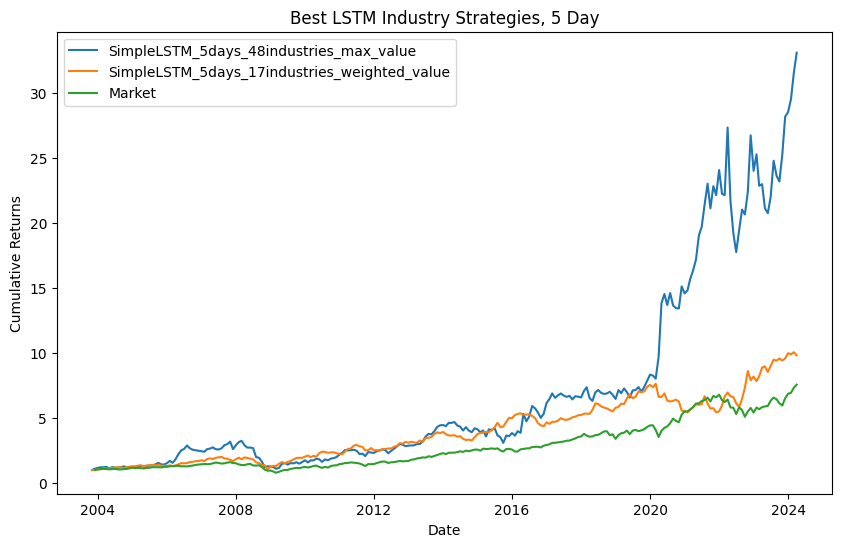

,alpha,alpha_annual,alpha_p_value,beta,sharpe
SimpleLSTM_5days_48industries_max_value,0.042,11.839,0.047,0.931,0.058
SimpleLSTM_5days_17industries_weighted_value,0.036,9.980,0.036,0.265,0.030


,alpha,alpha_annual,alpha_p_value,beta,sharpe


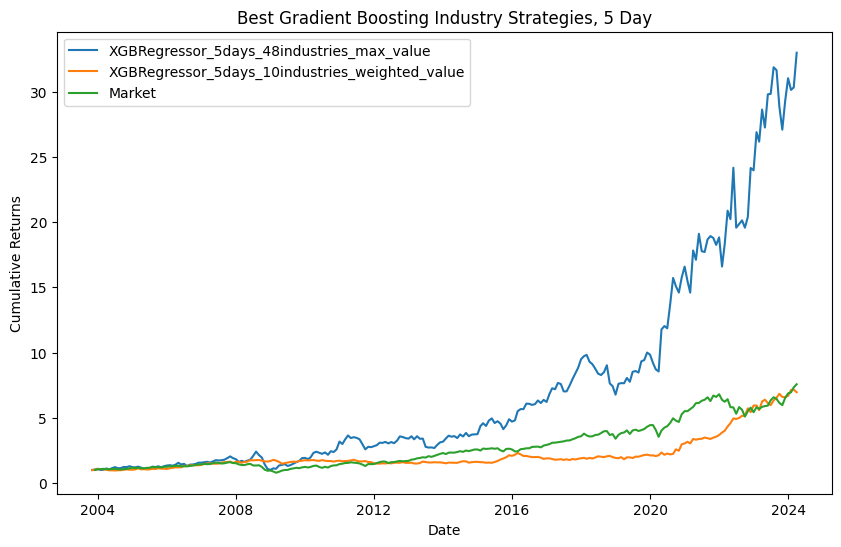

,alpha,alpha_annual,alpha_p_value,beta,sharpe
XGBRegressor_5days_48industries_max_value,0.040,11.126,0.046,0.983,0.047
XGBRegressor_5days_10industries_weighted_value,0.034,9.502,0.002,0.024,0.083


,alpha,alpha_annual,alpha_p_value,beta,sharpe


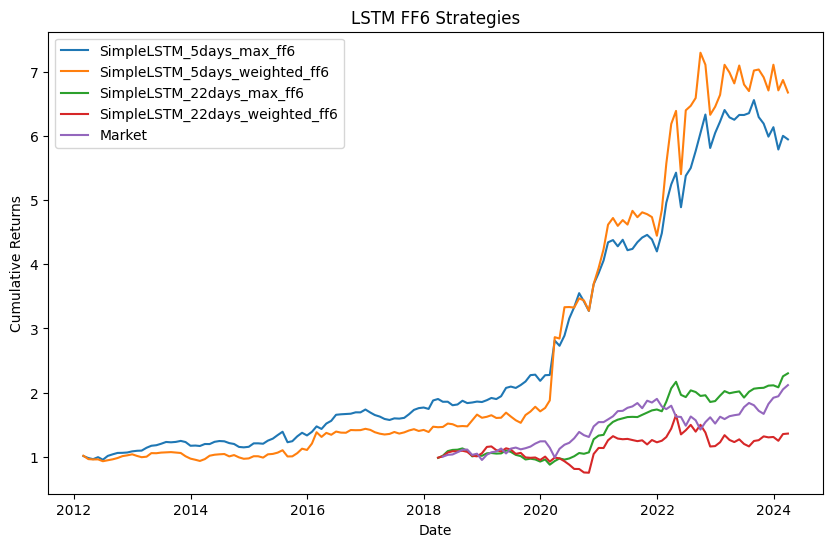

,alpha,alpha_annual,alpha_p_value,beta,sharpe
SimpleLSTM_5days_max_ff6,0.047,13.072,0.002,0.230,0.067
SimpleLSTM_5days_weighted_ff6,0.069,20.067,0.000,-0.073,0.072
SimpleLSTM_22days_max_ff6,0.042,11.627,0.135,0.275,0.046
SimpleLSTM_22days_weighted_ff6,0.026,7.220,0.480,-0.011,0.016


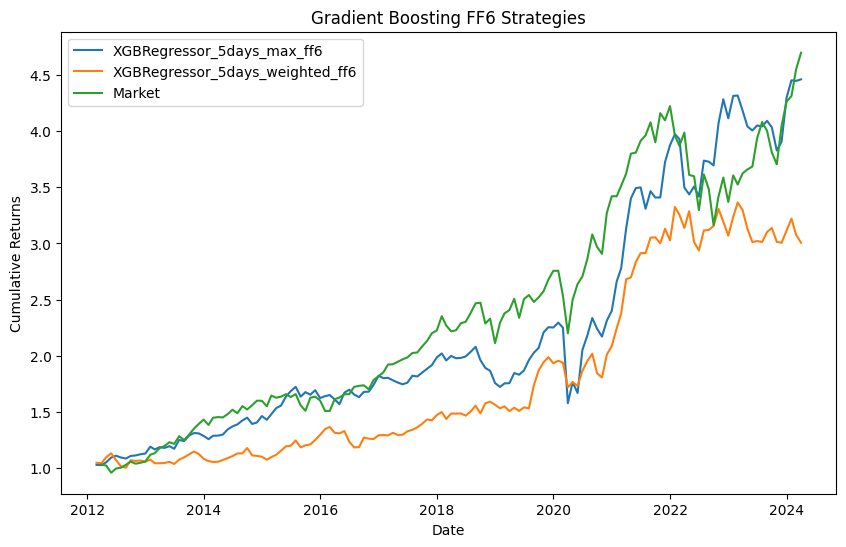

,alpha,alpha_annual,alpha_p_value,beta,sharpe
XGBRegressor_5days_max_ff6,0.037,10.139,0.013,0.245,0.048
XGBRegressor_5days_weighted_ff6,0.039,10.781,0.024,-0.021,0.040


In [28]:
plot_cum_rets(lstm_best_5, 'Best LSTM Industry Strategies, 5 Day')
# display but all numbers rounded to 3 decimal places
display(lstm_best_5_metrics.round(3))

plot_cum_rets(lstm_best_22, 'Best LSTM Industry Strategies, 22 Day')
display(lstm_best_22_metrics.round(3))

plot_cum_rets(XGBRegressor_best_5, 'Best Gradient Boosting Industry Strategies, 5 Day')
display(XGBRegressor_best_5_metrics.round(3))

plot_cum_rets(XGBRegressor_best_22, 'Best Gradient Boosting Industry Strategies, 22 Day')
display(XGBRegressor_best_22_metrics.round(3))

plot_cum_rets(lstm_best_ff6, 'LSTM FF6 Strategies') 
display(lstm_best_ff6_metrics.round(3))

plot_cum_rets(XGBRegressor_best_ff6, 'Gradient Boosting FF6 Strategies')
display(XGBRegressor_best_ff6_metrics.round(3))